# 0.0. Imports

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import gc
import pickle
import random
import warnings

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

## 0.1. Helper Functions

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()


In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [5]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v) for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable


In [6]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2_corrected = chi2 - (k-1)*(r-1)/(n-1)
    
    k_corrected = k - (k-1)**2/(n-1)
    
    r_corrected = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2_corrected/n) / ( min(k_corrected-1, r_corrected-1) ))


def mean_absolute_percentage_error(y, y_hat):
    return np.mean(np.abs((y - y_hat) / y))


def mean_percentage_error(y, y_hat):
    return np.mean((y - y_hat) / y)


def ml_error( model_name, y, y_hat):
    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse
                        }, 
                        index = [0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['date', 'sales'], axis = 1) 
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        y_hat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(y_hat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
                        }, index=[0])


## 0.2. Loading Data

In [7]:
df_sales_raw = pd.read_csv( 'Data/train.csv', low_memory = False )
df_store_raw = pd.read_csv( 'Data/store.csv', low_memory = False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )


# 1.0. Data Description

In [8]:
df1 = df_raw.copy()


## 1.1. Rename Columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Rename

df1.columns = cols_new

## 1.2. Data Dimensions

In [10]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )


Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
# competition_distance
## Distance in meters to the nearest competitor store
### Therefore, it is possible to consider the NA as a distance much bigger than the maximum in the database.
#### Max competition_distance = 75860.0

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
## Gives the approximate month of the time the nearest competitor was opened
### 2 reasons for being null: store has no nearest competitor or 
#### or the store has a competitor but the opening date is not known

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

# competition_open_since_year 
## Gives the approximate year of the time the nearest competitor was opened
### Same logic as the feature above

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )
                      
# promo2_since_week           
## Describes the calendar week when the store started participating in Promo2
### Same logic as the feature above

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )

#promo2_since_year           
## Describes the year when the store started participating in Promo2
### Same logic as the feature above

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

# promo_interval
## Describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" 
### means each round starts in February, May, August, November of any given year for that store
#### Create a dictionary to map months 1 to 12
##### Split this column and create a list, if the date is within the list,
###### create a column saying that promo2 was active

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )


In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [20]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes

In [21]:
# Central Tendencies - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion Tendencies - STD, Min, Max, Range, Skew, Kurtosis
dt1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
dt2 = pd.DataFrame( num_attributes.apply( min ) ).T
dt3 = pd.DataFrame( num_attributes.apply( max ) ).T
dt4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
dt5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
dt6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [dt2, dt3, dt4, ct1, ct2, dt1, dt5, dt6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [22]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

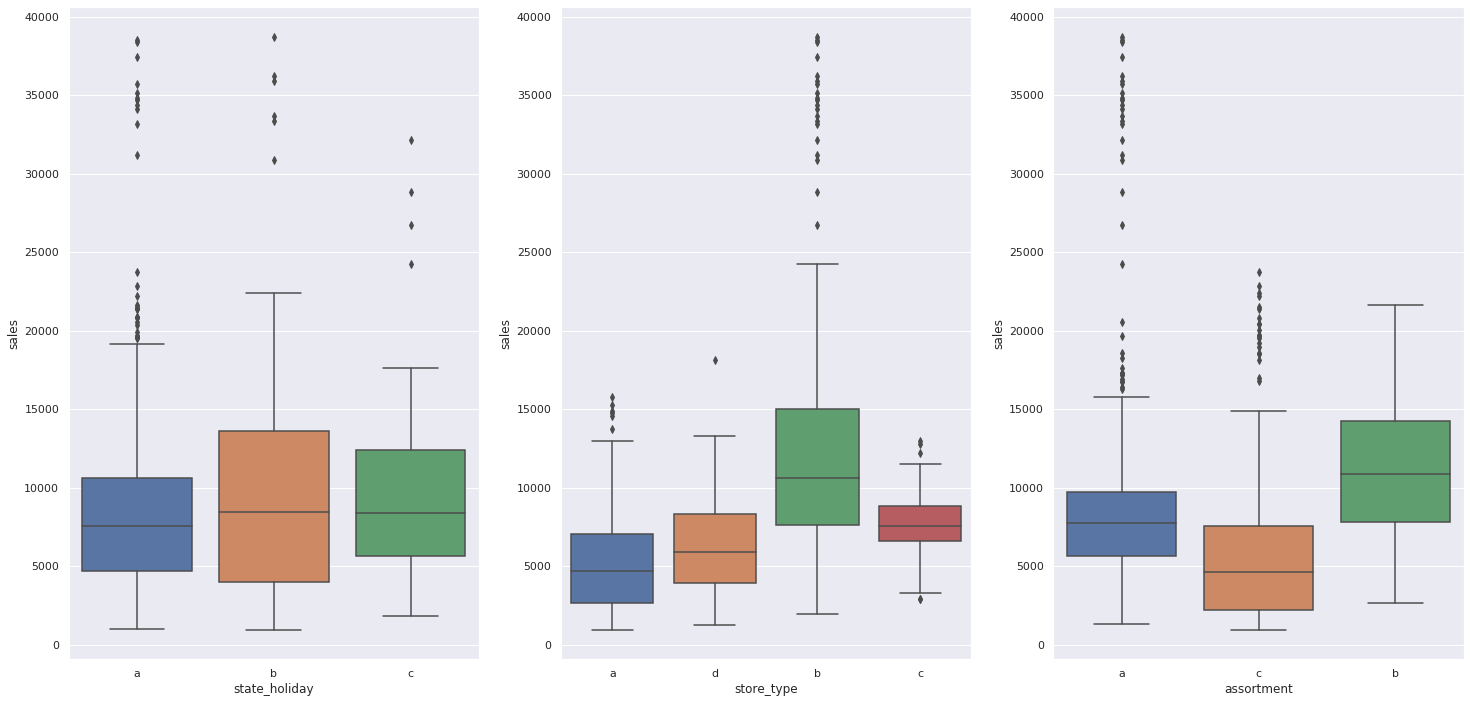

In [24]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0. Feature Engineering 

In [25]:
df2 = df1.copy()

## 2.1. Mind Map Hipothesis

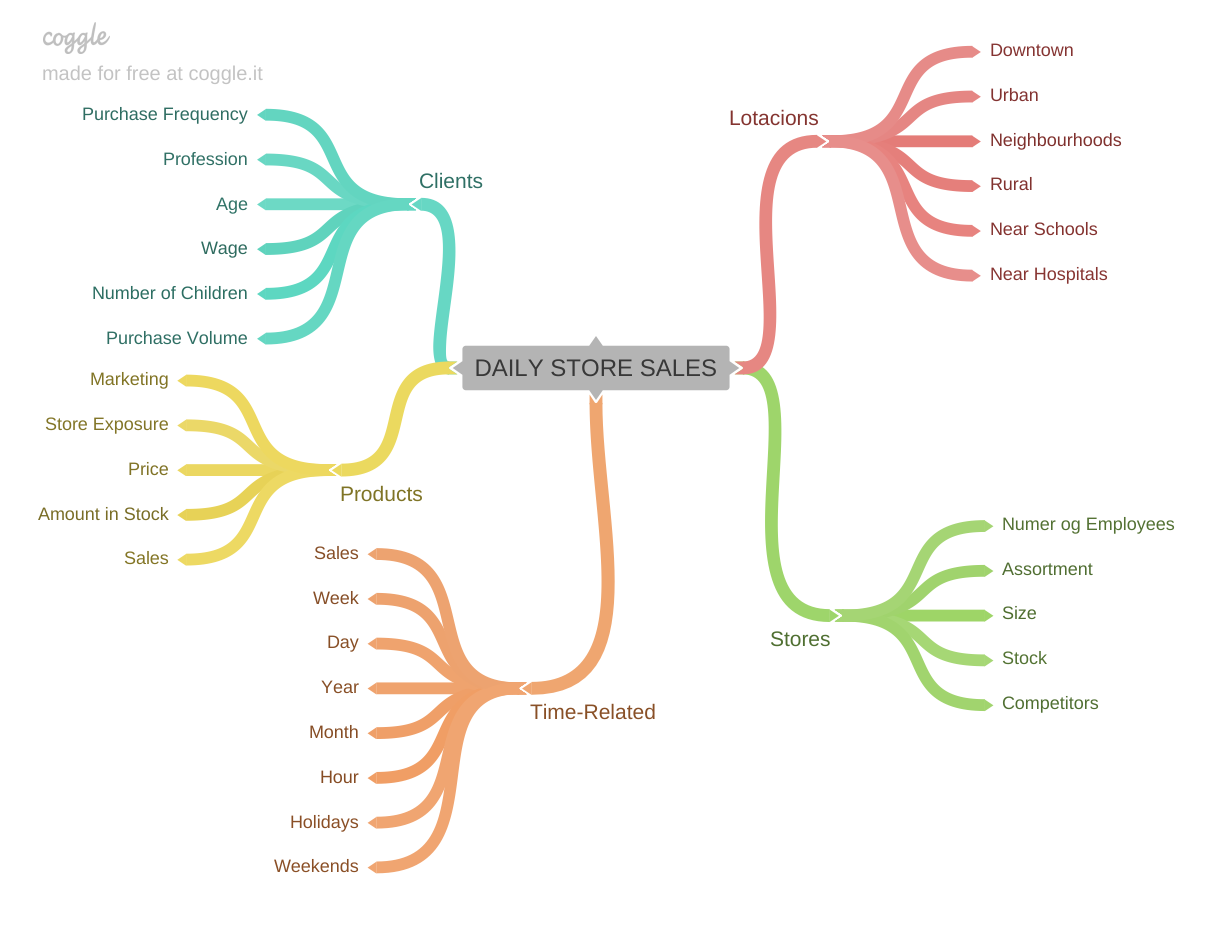

In [26]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1.Store Hypothesis

**1.** Stores with more employees should sell more

**2.** Stores with more inventory should sell more

**3.** Larger stores should sell more

**4.** Stores with a larger assortment should sell more

**5.** Stores with more competitors should sell less

**6.** Stores with longer-term competitors should sell less

### 2.2.2.Product Hypothesis

**1.** Stores that invest more in marketing should sell more

**2.** Stores that display more products in their showcases should sell more

**3.** Stores with lower prices should sell more

**4.** Stores with more aggressive promotions should sell more

**5.** Stores with promotions active for longer period of time should sell more

**6.** Stores with more days of promotions should sell more

**7.** Stores with more consecutive promotions should sell more

### 2.2.3. Time Hypothesis

**1.** Stores open during Christmas should sell more

**2.** Stores should sell more over the years

**3.** Stores should sell more in the second half of the year

**4.** Stores should sell more before the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

## 2.3. Final List of Hypotheses

**1.** Stores with a larger assortment should sell more

**2.** Stores with more competitors should sell less

**3.** Stores with longer-term competitors should sell less

**4.** Stores with promotions active for longer period of time should sell more

**5.** Stores with more days of promotions should sell more

**6.** Stores with more consecutive promotions should sell more

**7.** Stores open during Christmas should sell more

**8.** Stores should sell more over the years

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more before the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

## 2.4. Feature Engineering

In [27]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ), axis = 1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int 
                                                                                                      )
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' ) 

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 


In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Data Filtering

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Row Filtering

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column Selection

In [32]:
# "customers" column will not be available when making forecasts as we will not know how many customers will visit stores in the future;
# "open" column only has open stores, so it is redundant for the problem;
# "promo_interval" and "month_map" columns have already been used to derive new features, so they are not relevant.

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )


In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Exploratory Data Analysis

In [34]:
df4 = df3.copy()
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1. Univariate Analysis

### 4.1.1. Response Variable

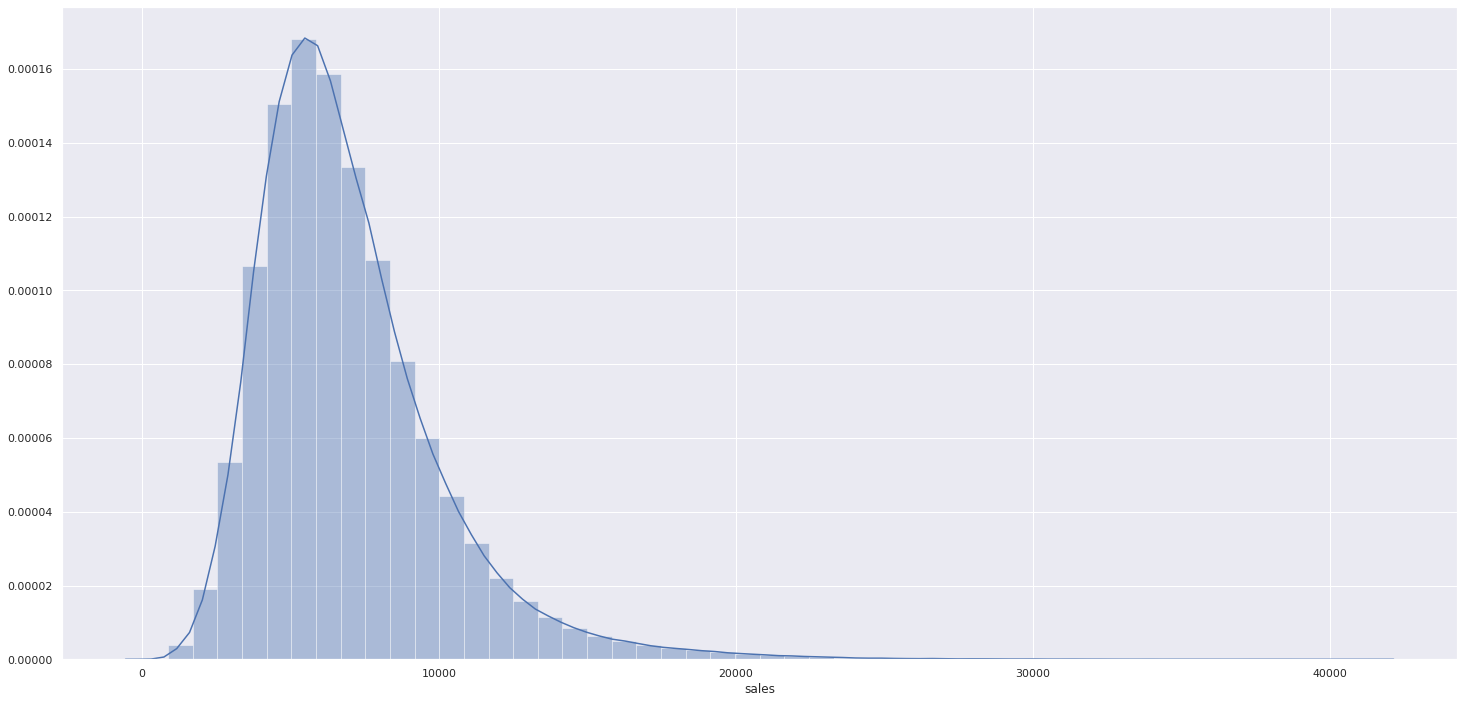

In [35]:
sns.distplot( df4.sales )

### 4.1.2. Numerical Variables

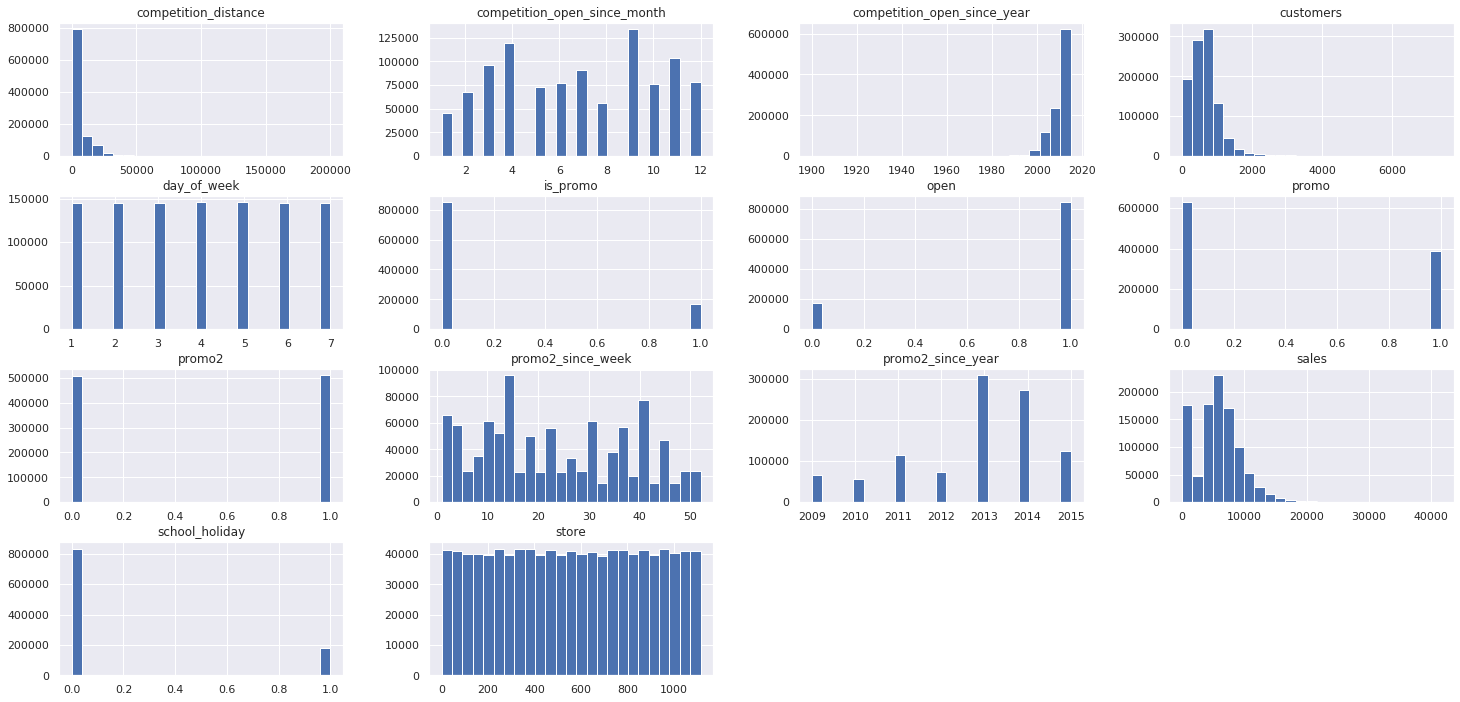

In [36]:
num_attributes.hist(bins = 25);

### 4.1.3. Categorical Variables

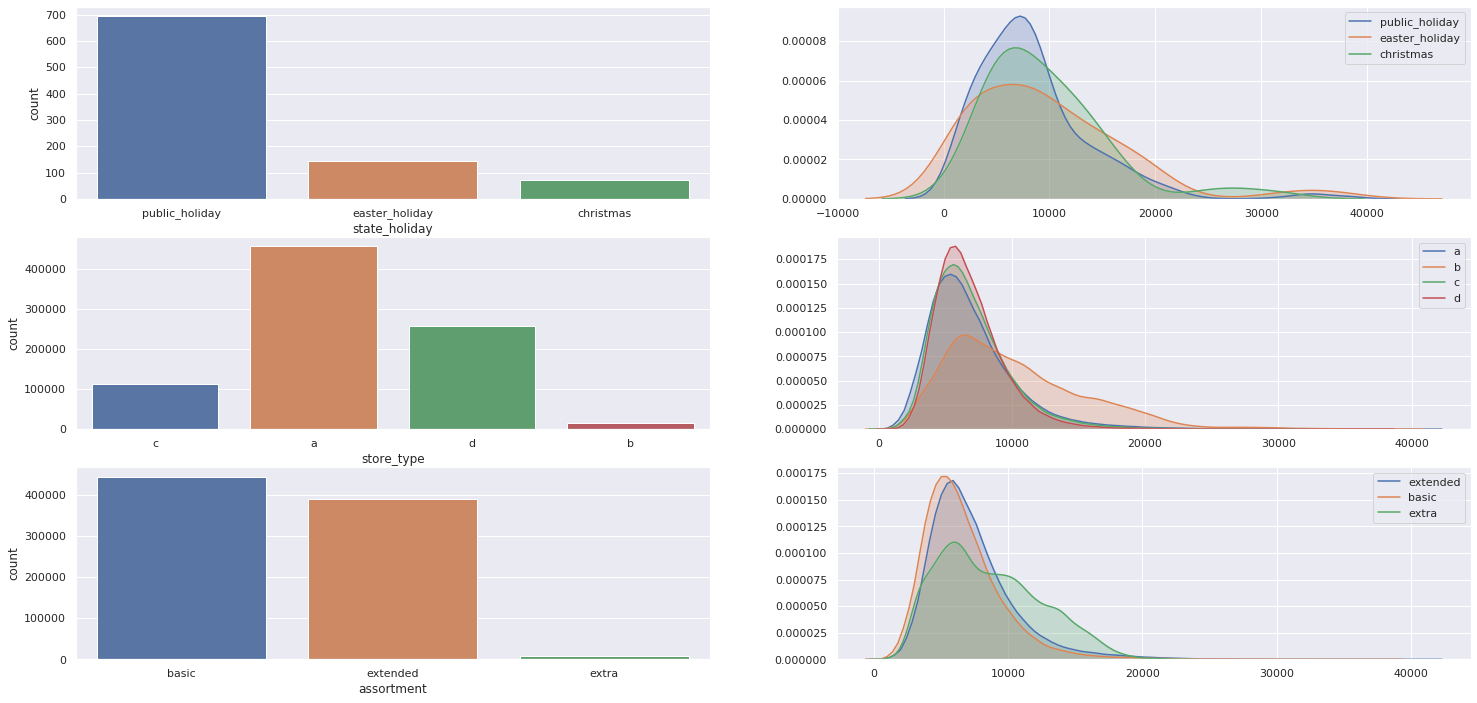

In [37]:
# state_holiday
plt.subplot( 3, 2, 1 )
sh = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( sh['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2. Bivariate Analysis

### **Hypothesis 1.** Stores with a larger assortment should sell more

**TRUE** Stores with LARGER ASSORTMENT have a HIGHER sales average.

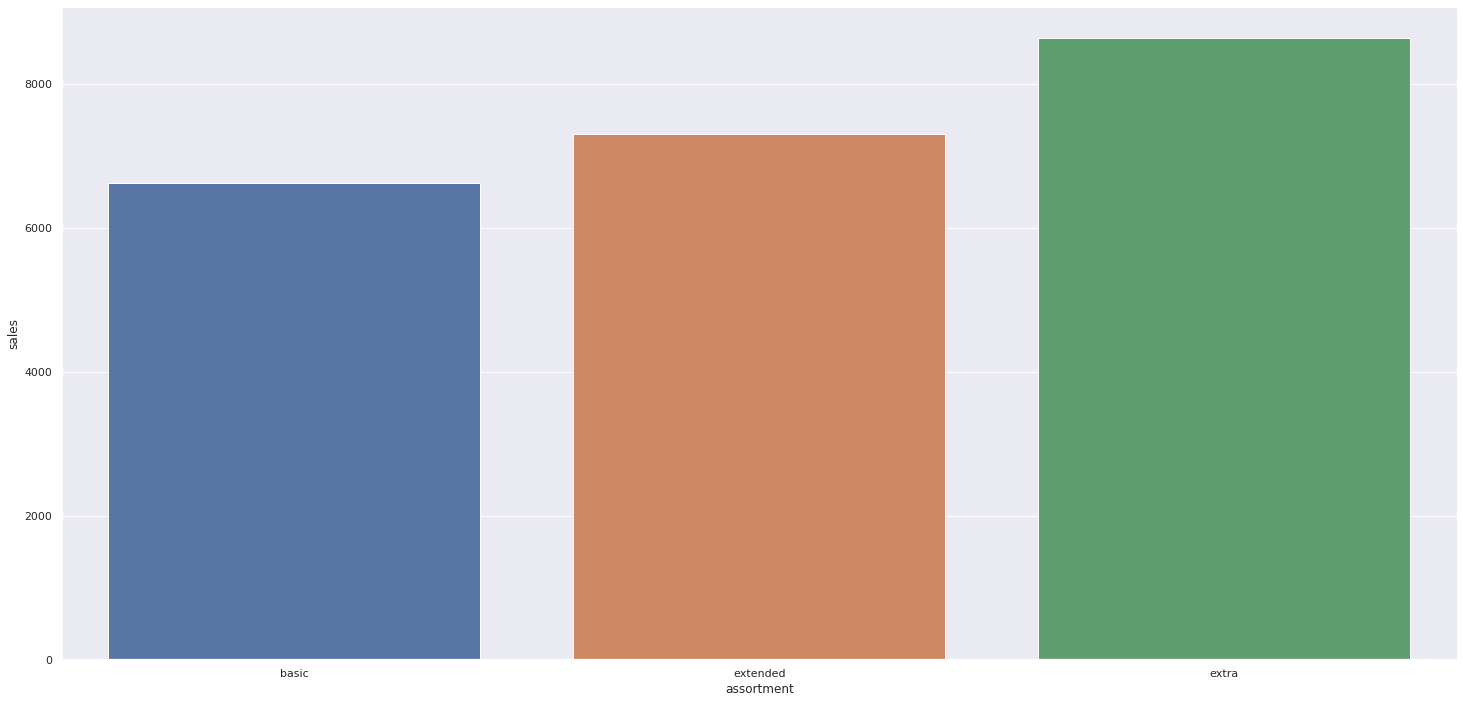

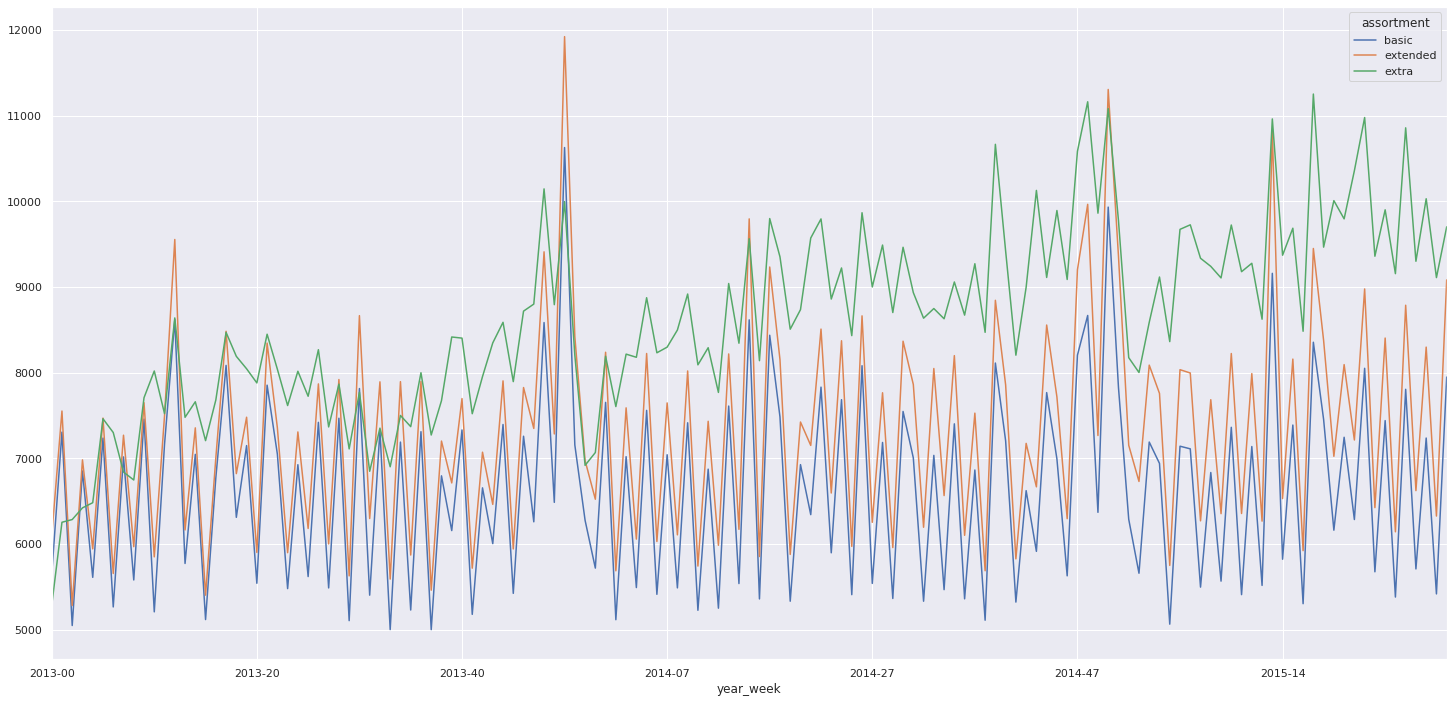

In [38]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

### **Hypothesis 2.** Stores with more competitors should sell less

**FALSE** Stores with CLOSER competitors sells MORE.

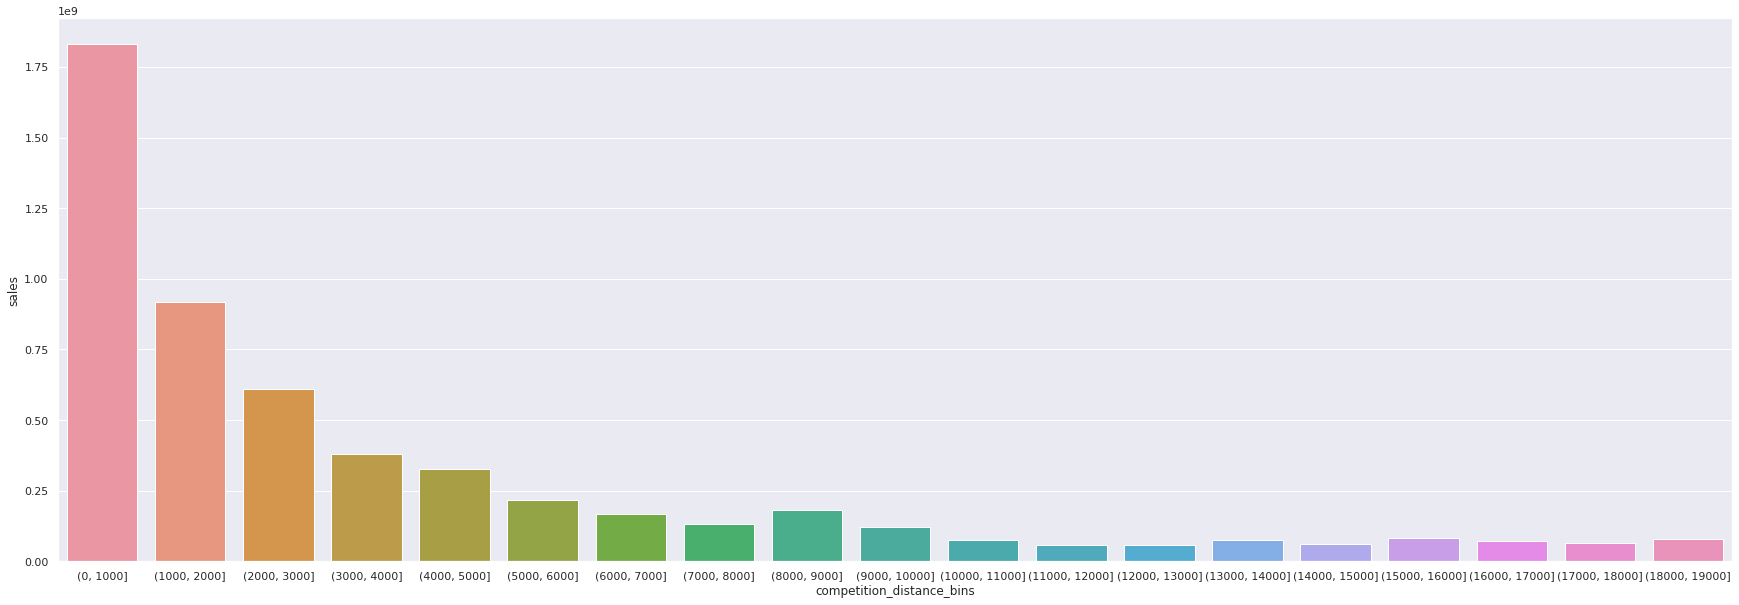

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_bins'] = pd.cut(aux1.competition_distance, bins = bins)
aux2 = aux1[['competition_distance_bins', 'sales']].groupby('competition_distance_bins').sum().reset_index()
plt.figure(figsize=(30,10))
sns.barplot(x = 'competition_distance_bins', y = 'sales', data = aux2);


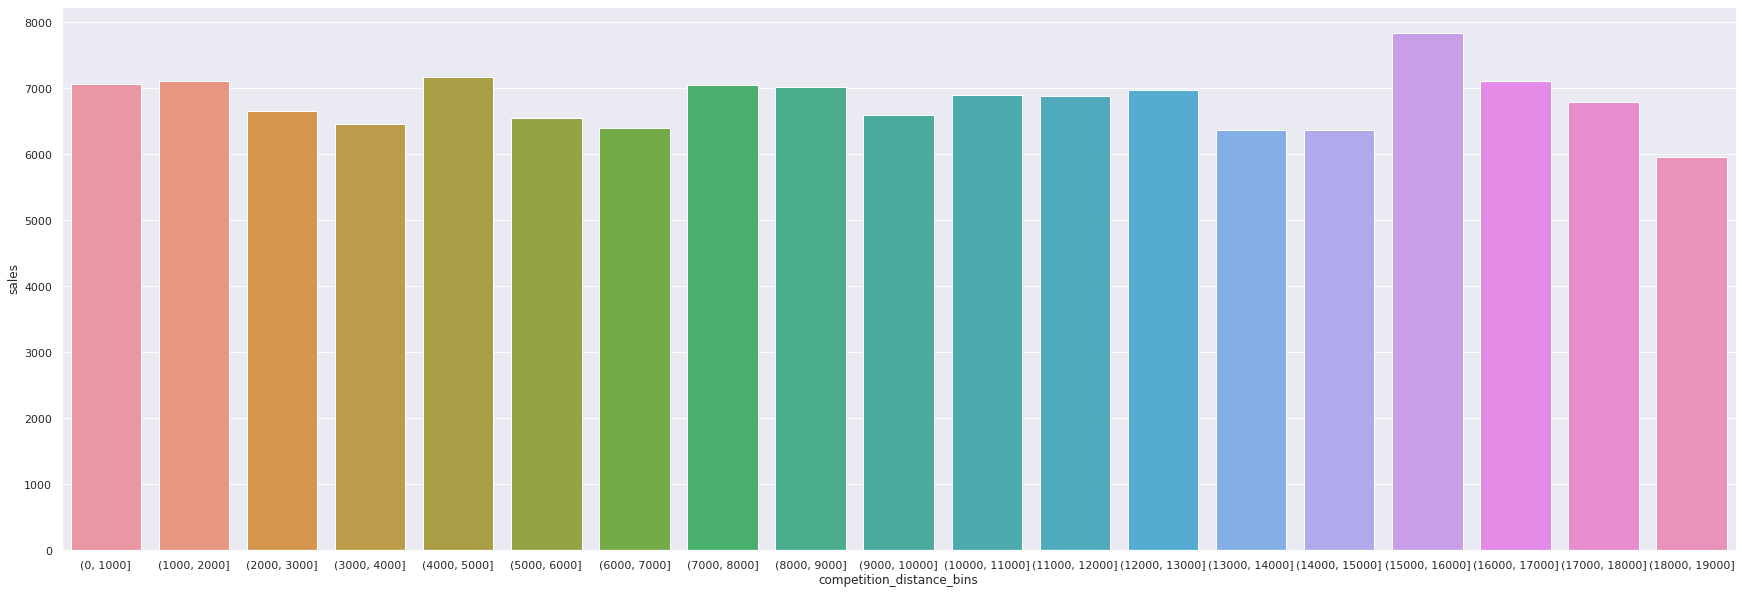

In [40]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_bins'] = pd.cut(aux1.competition_distance, bins = bins)
aux2 = aux1[['competition_distance_bins', 'sales']].groupby('competition_distance_bins').mean().reset_index()
plt.figure(figsize=(30,10))
sns.barplot(x = 'competition_distance_bins', y = 'sales', data = aux2);


### **Hypothesis 3.** Stores with longer-term competitors should sell less

**TRUE** Stores with longer-term competitors sell LESS

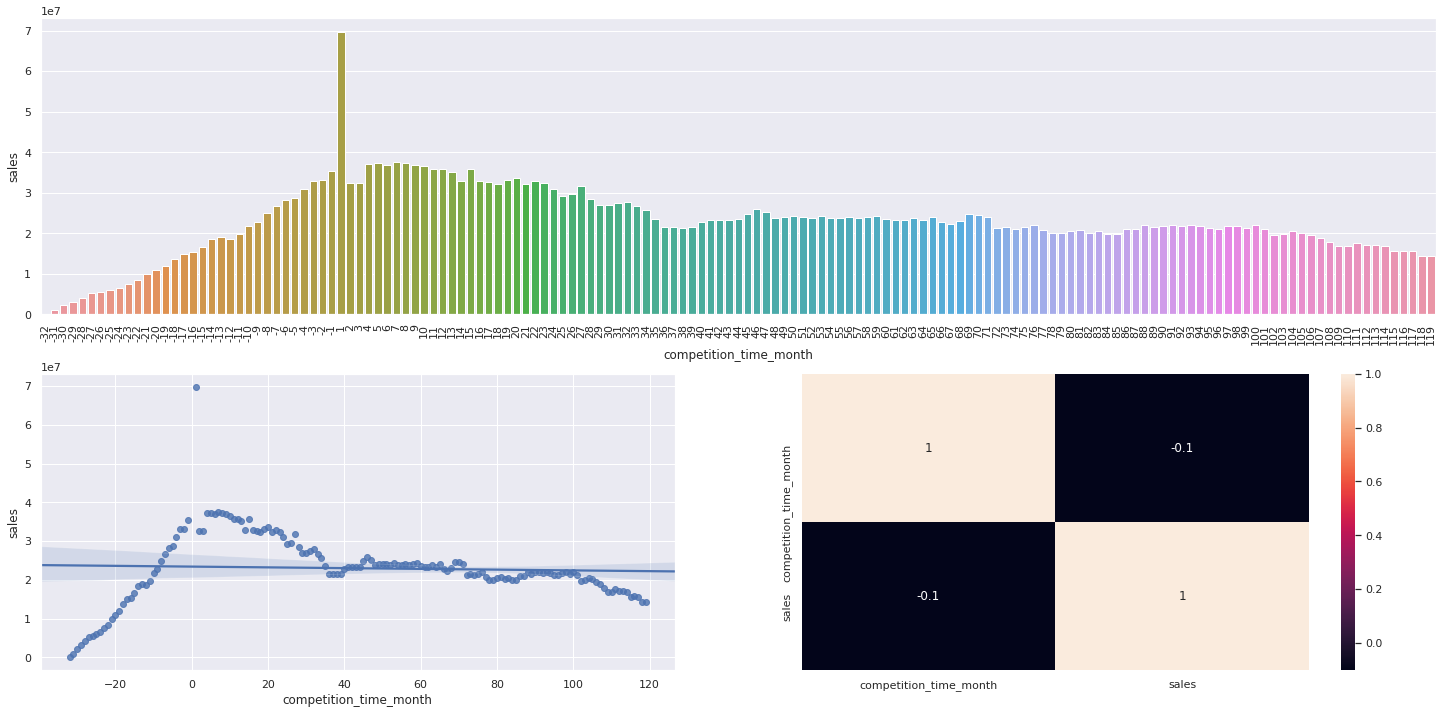

In [41]:
plt.subplot(2, 1, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 3)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(2, 2, 4)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True );

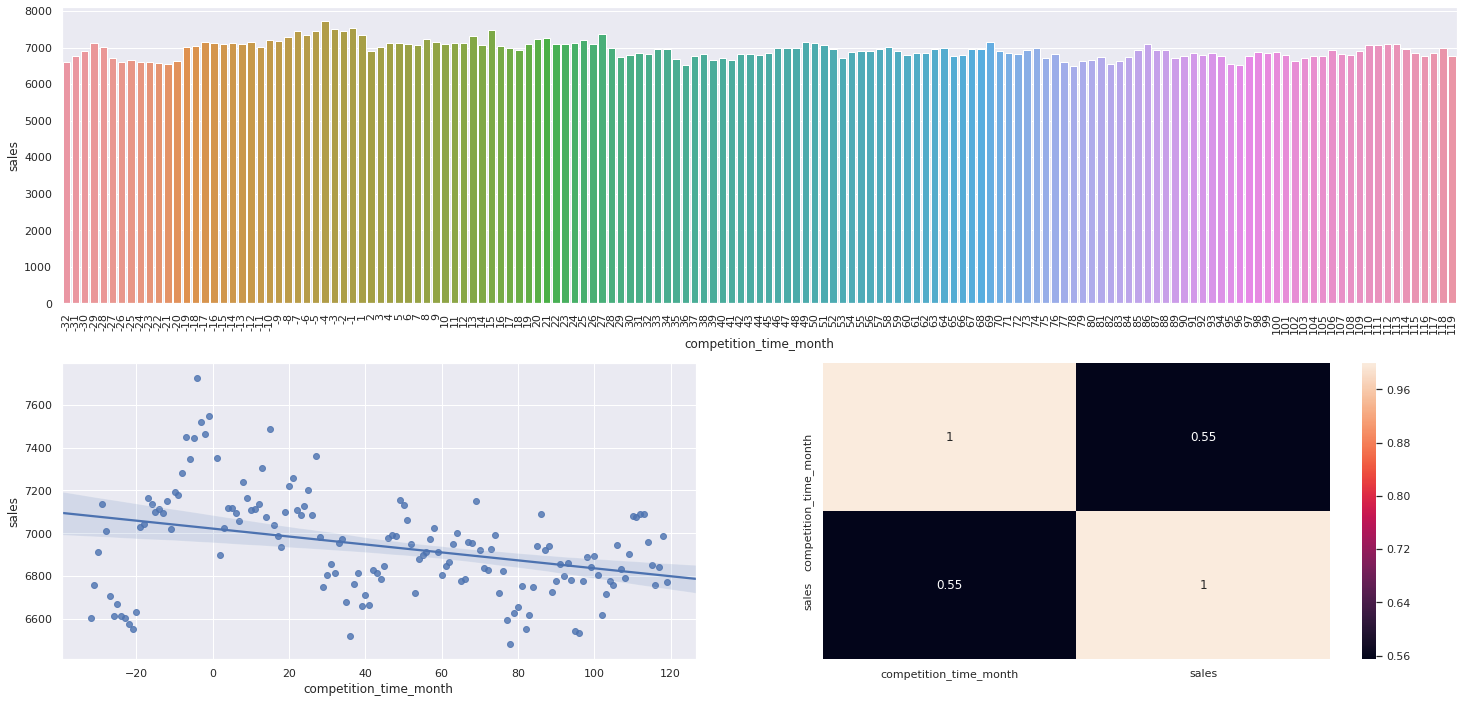

In [42]:
plt.subplot(2, 1, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(2, 2, 3)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(2, 2, 4)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True );

### **Hypothesis 4.** Stores with promotions active for longer period of time should sell more

**FALSE** Stores with promotions active for longer periods sell less after a certain amount of weeks


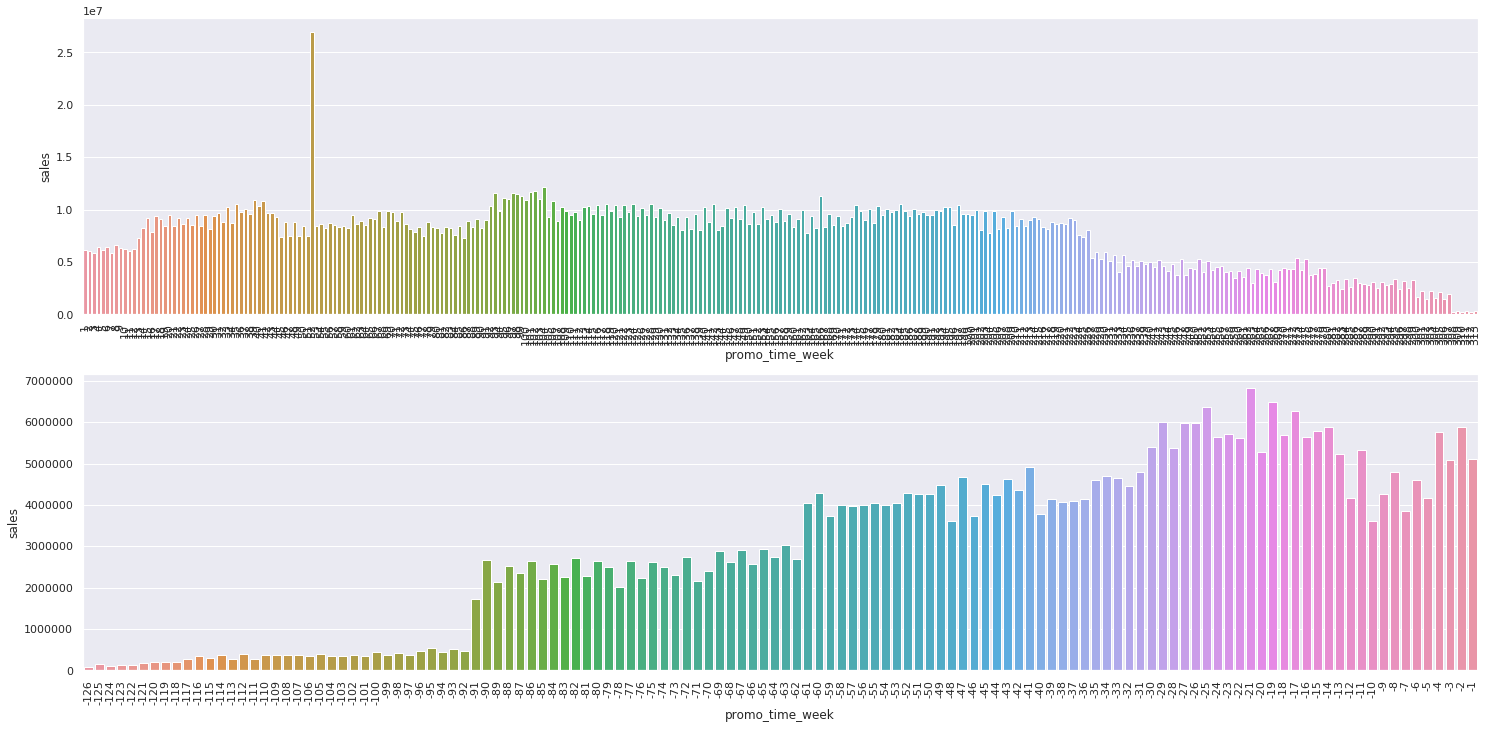

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2, 1, 1)
aux2 = aux1[(aux1['promo_time_week'] > 0)] # extended promotion
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(2, 1, 2)
aux3 = aux1[(aux1['promo_time_week'] < 0)] # regular promotion
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);


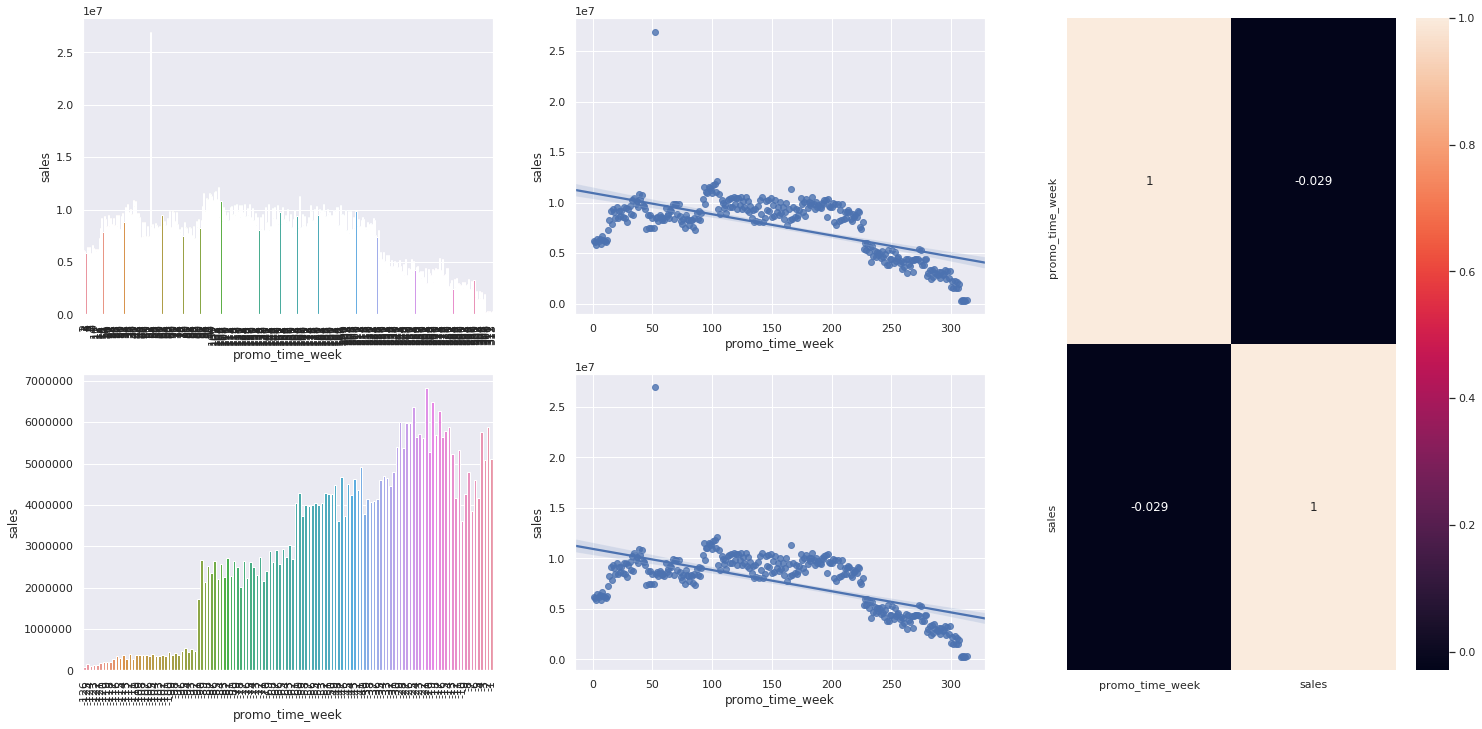

In [44]:
grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[1,0])
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[:,2])
x = sns.heatmap(aux1.corr(method='pearson'), annot=True );


### **Hypothesis 5.** Stores with more days of promotions should sell more



### **Hypothesis 6.** Stores with more consecutive promotions should sell more

**FALSE** Stores with extended promotions have similar sales compared with store with regular promotions


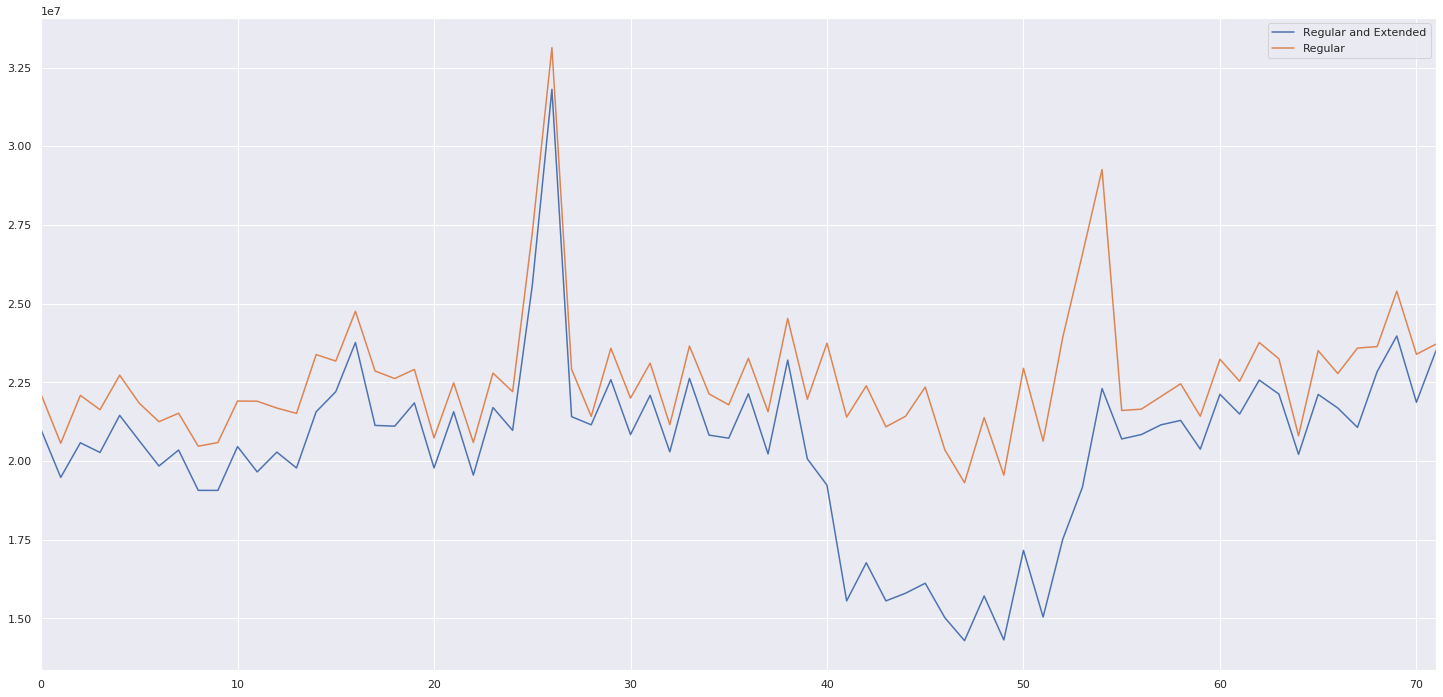

In [45]:
aux1 = df4[(df4["promo"] == 1) & (df4["promo2"] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4["promo"] == 1) & (df4["promo2"] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend( labels = ['Regular and Extended', 'Regular']);


### **Hypothesis 7.** Stores open during Christmas should sell more
**TRUE** On average, stores opened during Christmas have higher sales 

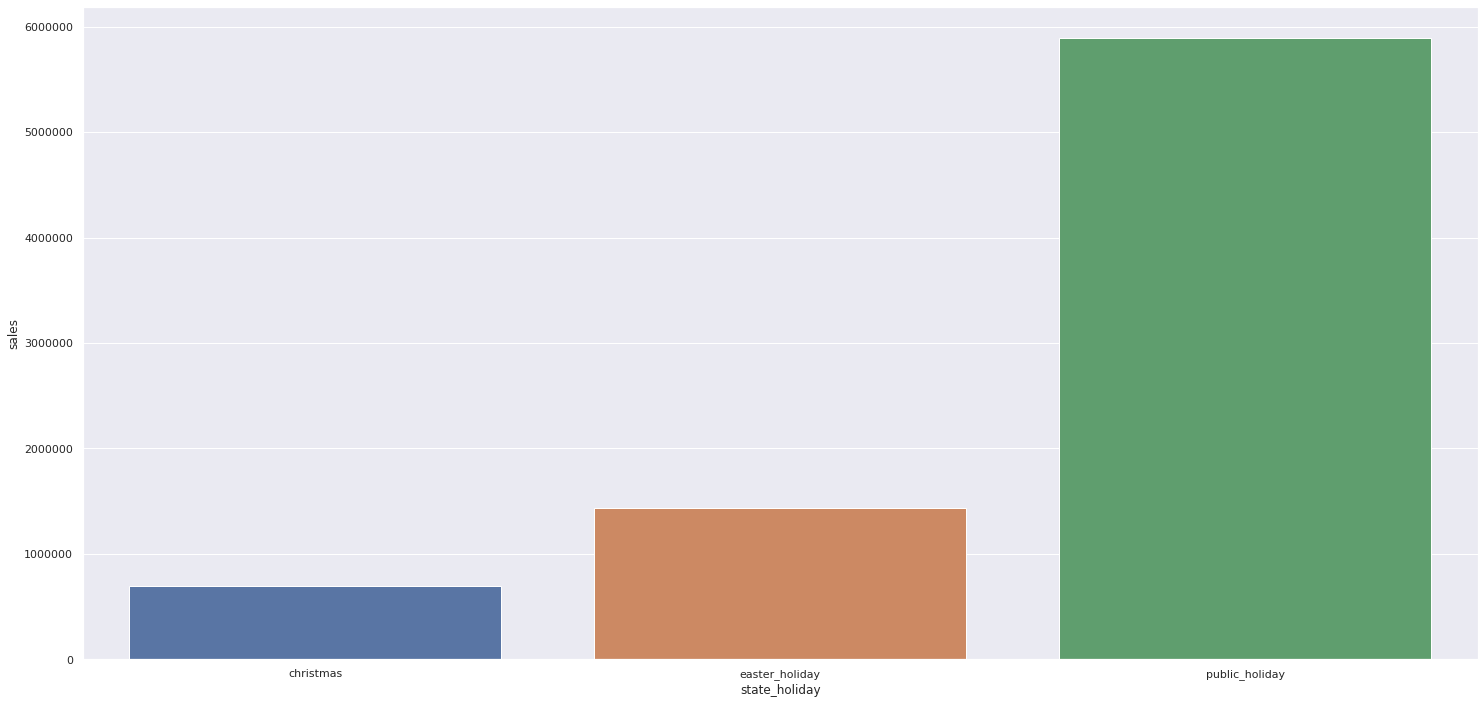

In [46]:
aux1 = df4[df4['state_holiday'] != 'regular_day']

aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

sns.barplot(x = 'state_holiday', y = 'sales', data = aux2);


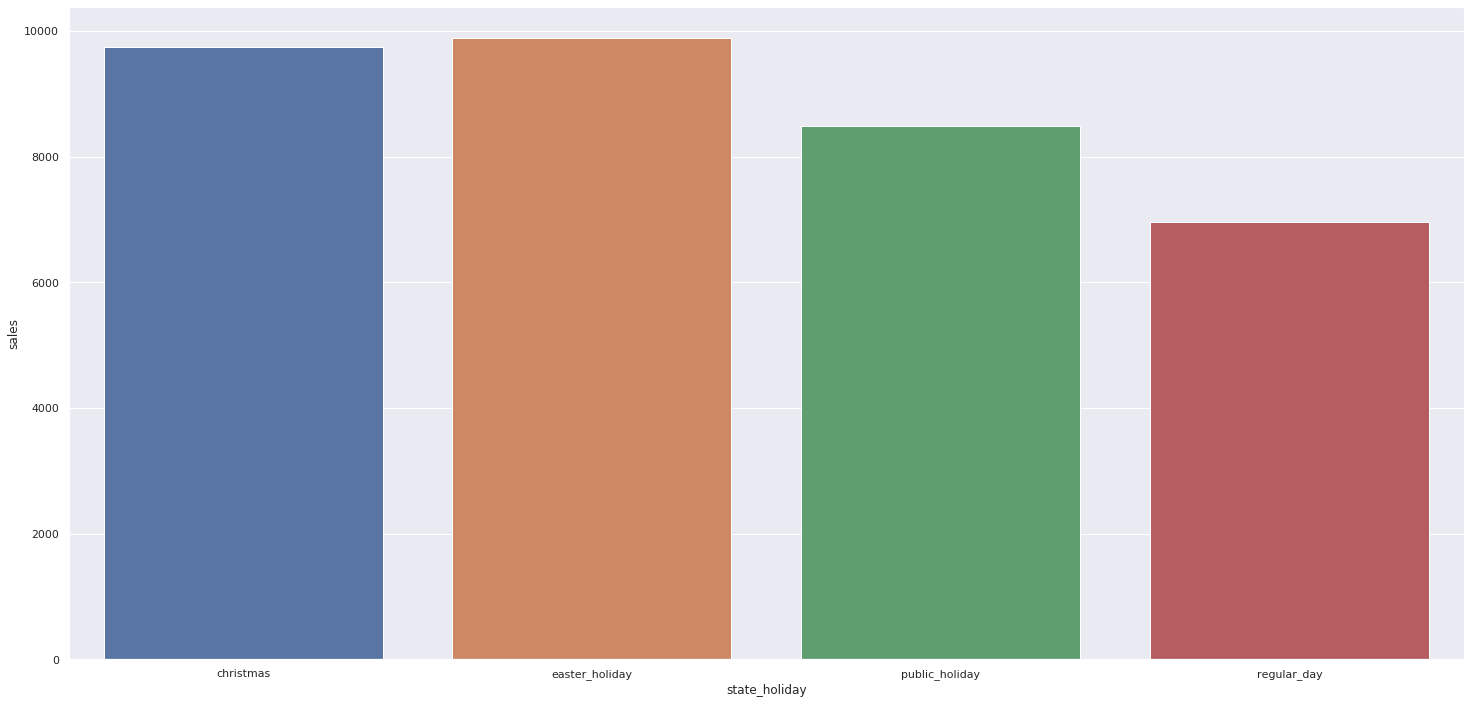

In [47]:
aux3 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()

sns.barplot(x = 'state_holiday', y = 'sales', data = aux3);


### **Hypothesis 8.** Stores should sell more over the years

**FALSE** Store Sales have been decreasing over time (*2015 sales values are not complete due to the fact that data is not available for the whole year)

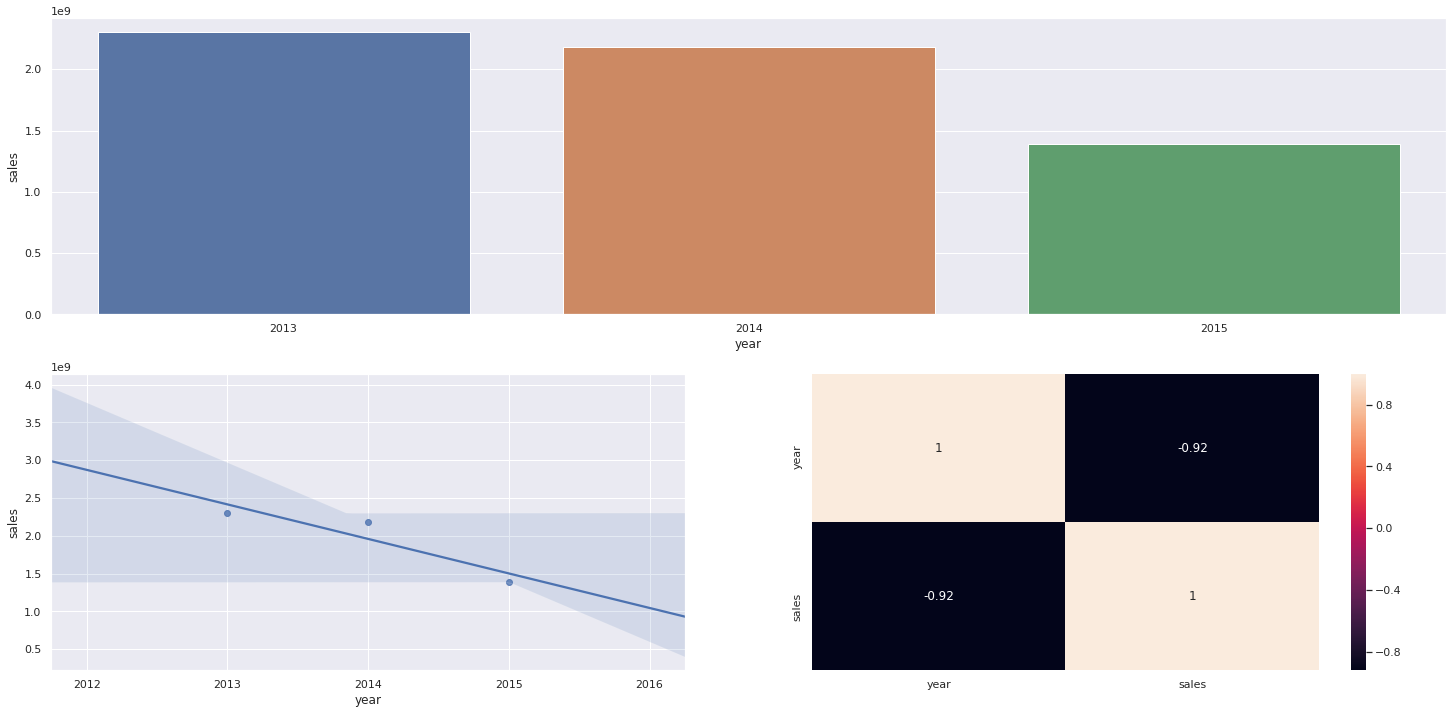

In [48]:
plt.subplot(2, 1, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(2, 2, 4)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True );


### **Hypothesis 9.** Stores should sell more in the second half of the year

**TRUE** On Average, Stores sell more in the second half of the year

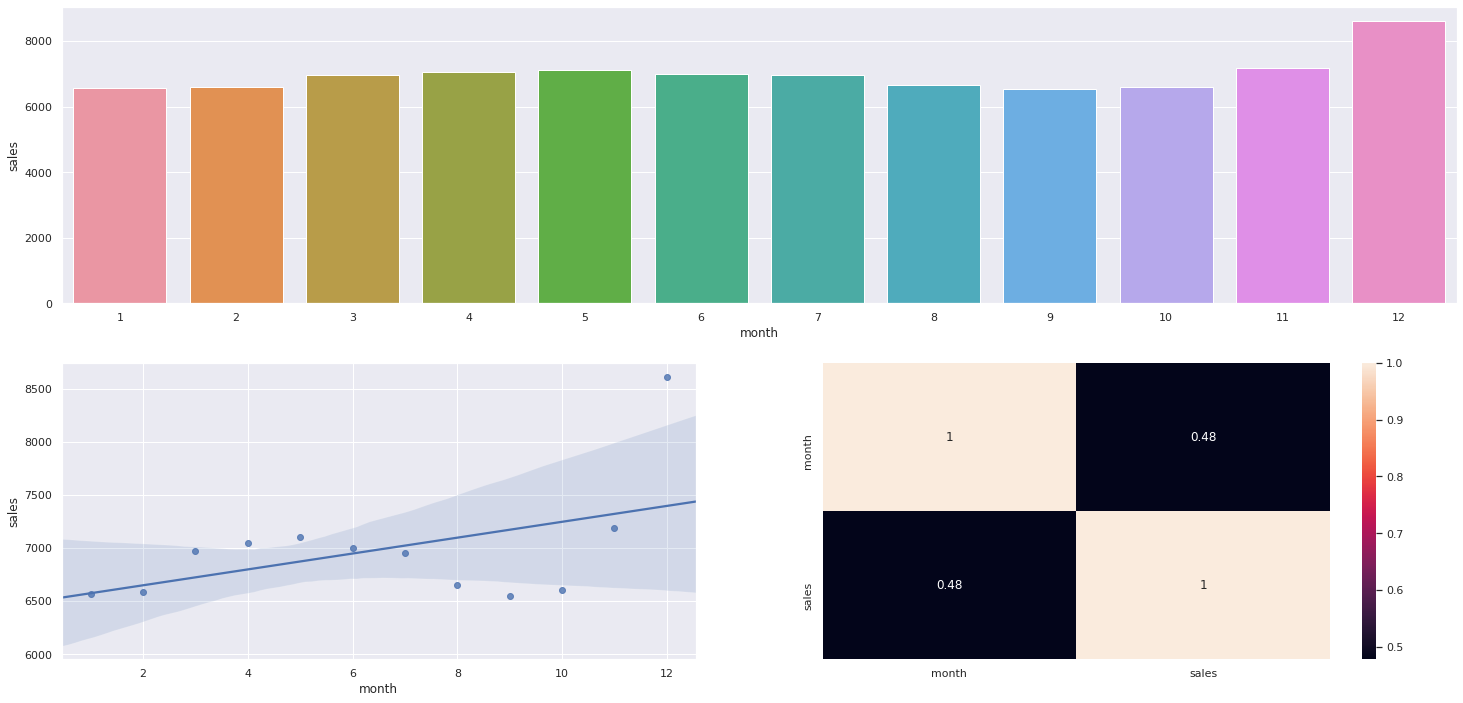

In [49]:
plt.subplot(2, 1, 1)
aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(2, 2, 4)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True );


### **Hypothesis 10.** Stores should sell more before the 10th of each month

**TRUE** On average, stores sells more before the 10th of each month

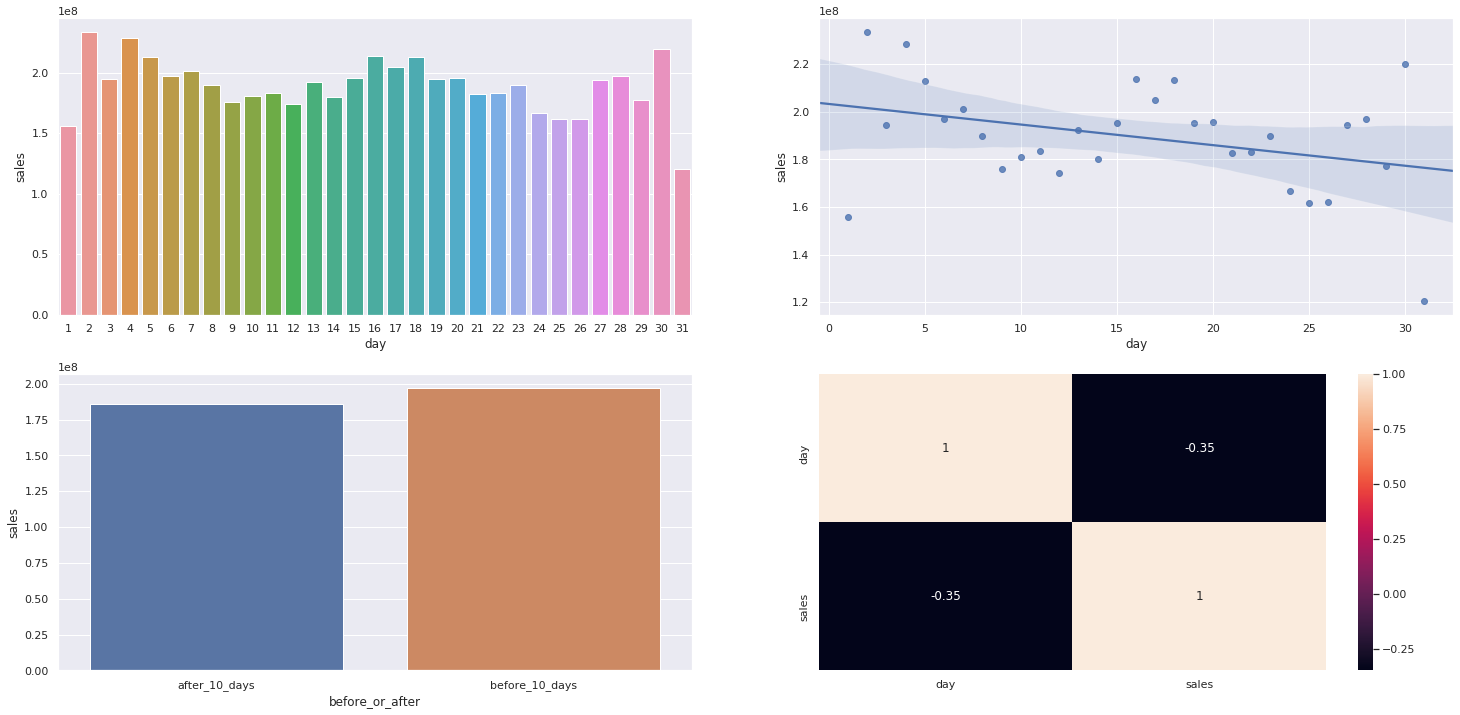

In [50]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_or_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_or_after', 'sales']].groupby('before_or_after').mean().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
sns.barplot(x = 'before_or_after', y = 'sales', data = aux2);

plt.subplot(2, 2, 4)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True );


### **Hypothesis 11.** Stores should sell less on weekends

**TRUE** Stores sells less on weekends

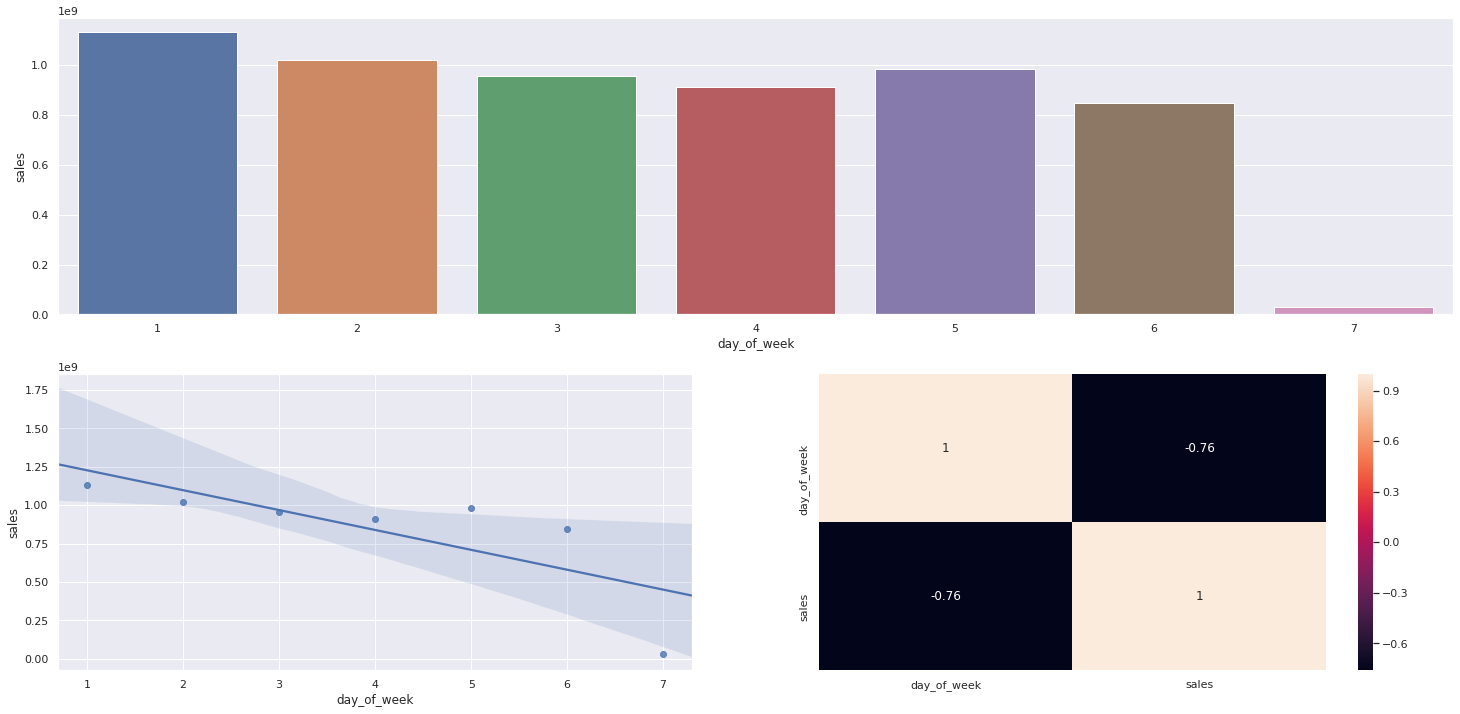

In [51]:
plt.subplot(2, 1, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(2, 2, 3)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(2, 2, 4)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True );


### **Hypothesis 12.** Stores should sell less during school holidays

**FALSE** On average, Stores sell more during school holidays

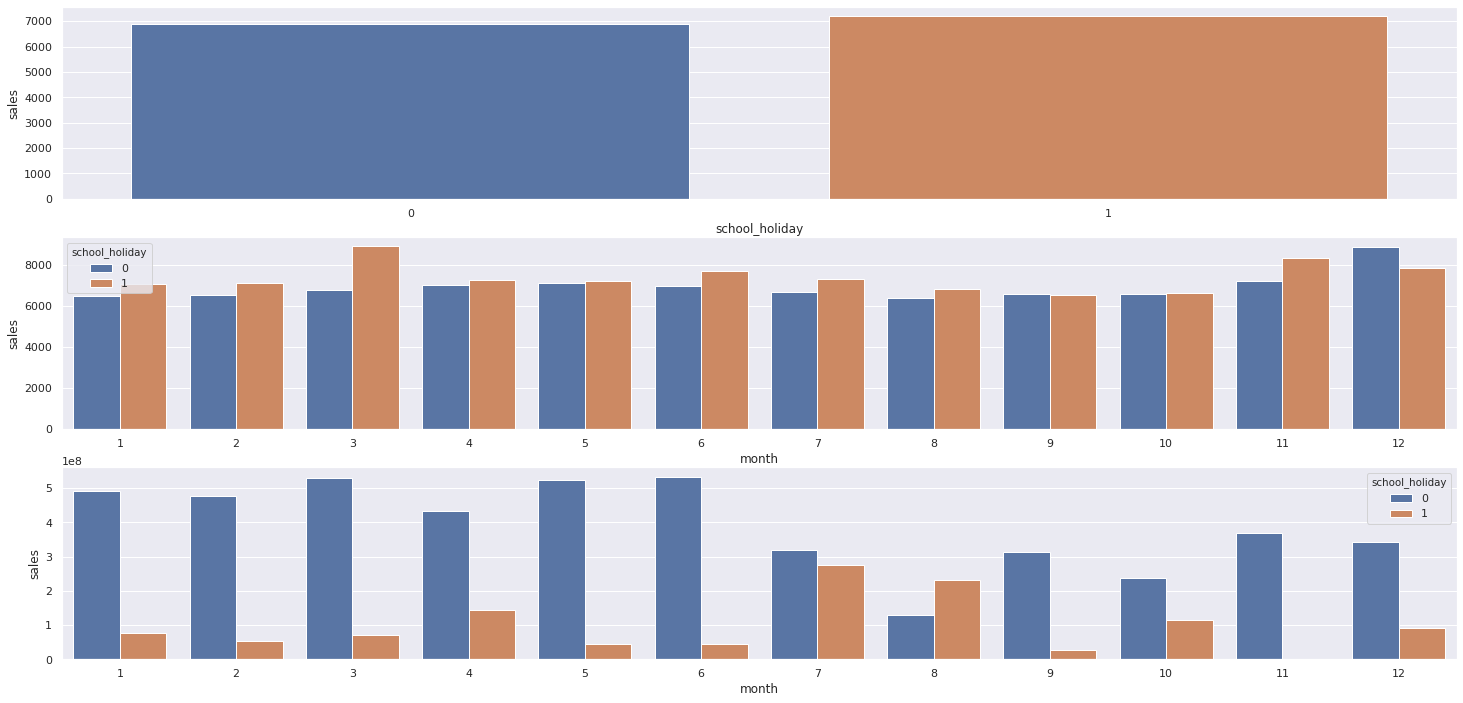

In [52]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(3,1,1)
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()

plt.subplot(3,1,2)
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);


aux3 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(3,1,3)
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux3);


## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

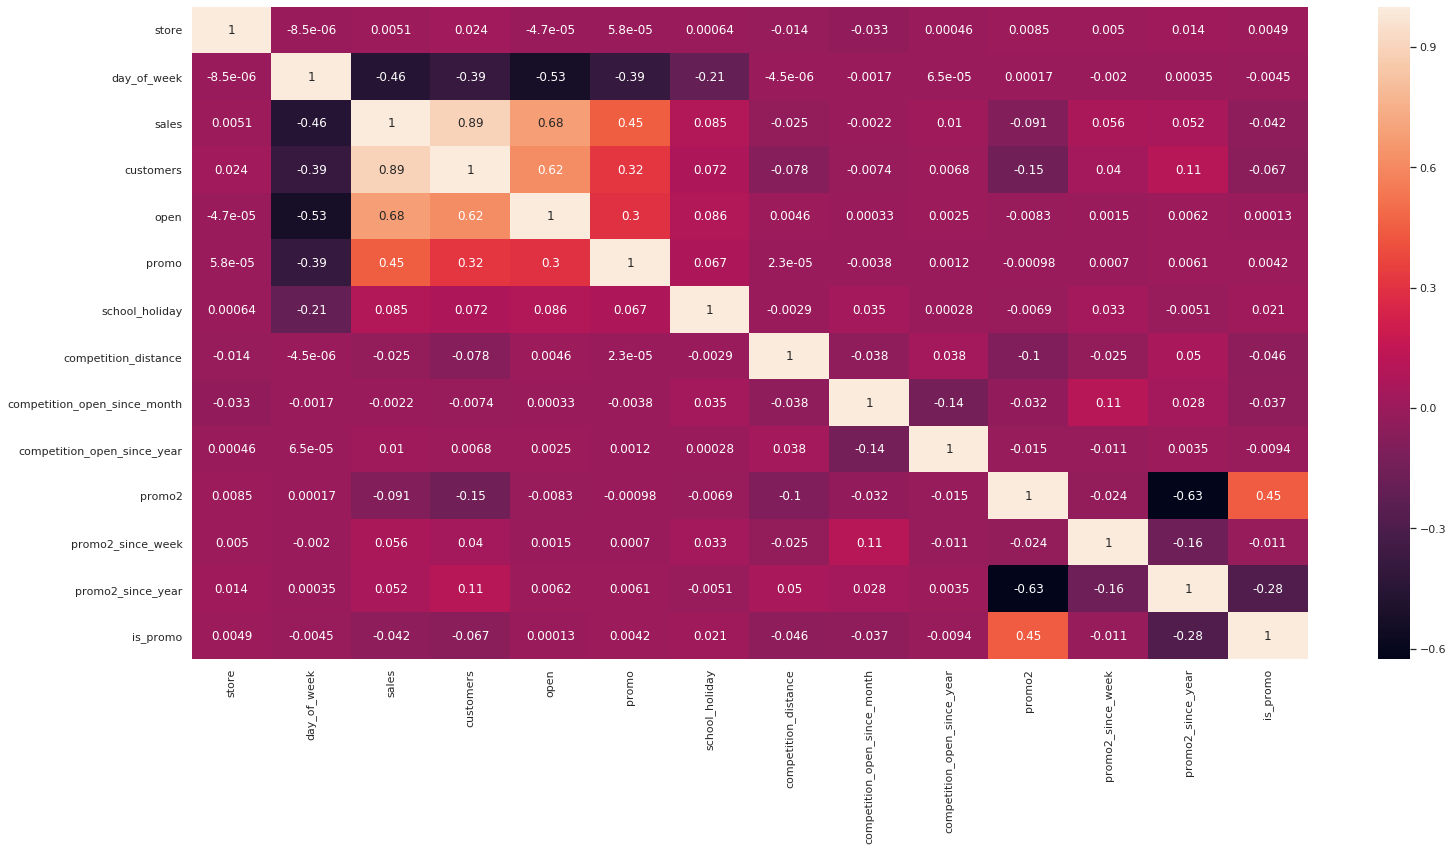

In [53]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);


### 4.3.2 Categorical Attributes

In [54]:
cat = df4.select_dtypes(include = 'object')
cat.drop('year_week', axis = 1, inplace = True)
cat.head()


,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


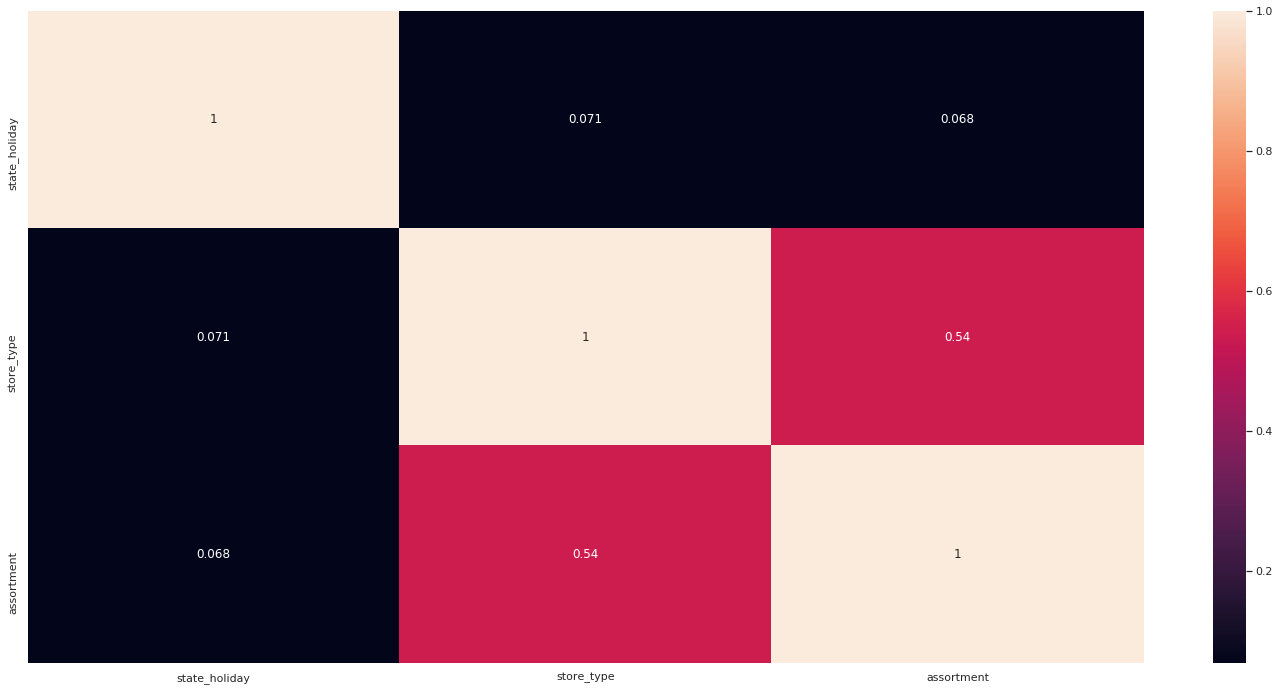

In [55]:
cat1 = cramer_v(cat['state_holiday'], cat['state_holiday'])
cat2 = cramer_v(cat['state_holiday'], cat['store_type'])
cat3 = cramer_v(cat['state_holiday'], cat['assortment'])

cat4 = cramer_v(cat['store_type'], cat['state_holiday'])
cat5 = cramer_v(cat['store_type'], cat['store_type'])
cat6 = cramer_v(cat['store_type'], cat['assortment'])

cat7 = cramer_v(cat['assortment'], cat['state_holiday'])
cat8 = cramer_v(cat['assortment'], cat['store_type'])
cat9 = cramer_v(cat['assortment'], cat['assortment'])

cat_df = pd.DataFrame( {'state_holiday': [cat1, cat2, cat3],
               'store_type': [cat4, cat5, cat6],
               'assortment': [cat7, cat8, cat9]
              } )
cat_df = cat_df.set_index(cat_df.columns)

sns.heatmap(cat_df, annot = True);


# 5.0. Data Preparation

In [56]:
df5 = df4.copy()

## 5.1. Normalization

In this dataset, no numerical variable follow the normal distribution, therefore no normalization was made

## 5.2. Rescaling

In [57]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('./Parameters/competition_distance_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('./Parameters/year_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('./Parameters/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('./Parameters/promo_time_week_scaler.pkl', 'wb'))


## 5.3. Variable Transformation

### 5.3.1. Encoding

In [58]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])


In [59]:
# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('./Parameters/store_type_encoder.pkl', 'wb'))


In [60]:
# assortment
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2. Response Variable

In [61]:
df5['sales'] = np.log1p(df5['sales'])


### 5.3.3. Nature Transformation

In [62]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))


# 6.0. Feature Selection

In [63]:
df6 = df5.copy()


## 6.1. Training / Test Database

In [64]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)


In [65]:
# Training data
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test data
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']


x_train_min = X_train['date'].min()
x_train_max = X_train['date'].max()

x_test_min = X_test['date'].min()
x_test_max = X_test['date'].max()

print(f'Training Min Date: {x_train_min}')
print(f'Training Max Date: {x_train_max}\n')

print(f'Test Min Date: {x_test_min}')
print(f'Test Max Date: {x_test_max}')


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta Feature Selector

In [66]:
# training and test data for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
Y_train_n = Y_train.values.ravel()


In [67]:
# RandomForestRegressor
#rf = RandomForestRegressor(n_jobs = 1)

# Boruta
#boruta = BorutaPy(rf, n_estimators = 20, verbose = 2, random_state = 42).fit(X_train_n, Y_train_n)


### 6.2.1. Features selected from Boruta

In [68]:
#cols_selected = boruta.support_.tolist()

# Selected Features
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Not Selected Features
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [69]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']


In [70]:
# Columns to Add
feat_to_add = ['date', 'sales']

# Final Features
#cols_selected_boruta.extend(feat_to_add)
cols_selected_full = cols_selected_boruta.copy()
cols_selected_full.extend(feat_to_add)


# 7.0. Machine Learning Models

In [71]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_full ]

## 7.1. Average Model

In [72]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# Predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
y_hat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(y_hat_baseline))

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [73]:
# Model
lr = LinearRegression().fit(x_train, Y_train_n)

# Prediction
y_hat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(y_hat_lr))

lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Cross Validation 

In [74]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Regularized Linear Regression Model - Lasso

In [75]:
# Model
rlr = Lasso(alpha = 0.01).fit(x_train, Y_train_n)

# Prediction
y_hat_rlr = rlr.predict(x_test)

# Performance
rlr_result = ml_error('Regularized Linear Regression - Lasso', np.expm1(Y_test), np.expm1(y_hat_rlr))

rlr_result

,Model Name,MAE,MAPE,RMSE
0,Regularized Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Cross Validation 

In [76]:
rlr_result_cv = cross_validation( x_training, 5, 'Regularized Linear Regression', rlr, verbose=False )
rlr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Regularized Linear Regression,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Model

In [77]:
# Model
#rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, Y_train_n)


In [78]:
#Saving Trained Model
filename_rf = './Models/random_forest.sav'
#pickle.dump(rf_save, open(filename_rf, 'wb'))


In [79]:
#Loading Trained Model
#loaded_rf = pickle.load(open(filename_rf, 'rb'))

# Prediction
#y_hat_rf = loaded_rf.predict(x_test)

# Performance
#rf_result = ml_error('Random Forest', np.expm1(Y_test), np.expm1(y_hat_rf))

#rf_result


### 7.4.1 Cross Validation

In [80]:
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest', rf, verbose=True )
#rf_result_cv

## 7.5. XGBoost Regressor Model

In [81]:
# Model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.3,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytree = 0.9)

#model_xgb.fit(x_train, Y_train_n)

#Saving Trained Model
filename_xgb = './Models/xgboost.sav'
#pickle.dump(model_xgb, open(filename_xgb, 'wb'))


In [82]:
#Loading Trained Model
loaded_xgb = pickle.load(open(filename_xgb, 'rb'))

# Prediction
y_hat_xgb = loaded_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost', np.expm1(Y_test), np.expm1(y_hat_xgb))

xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,890.527565,0.129193,1306.496922


### 7.5.1 Cross Validation

In [83]:
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost', model_xgb, verbose=False )
#xgb_result_cv

## 7.6 Model Performance Comparison

### 7.6.1. Single Fold Performance

In [84]:
#modeling_result = pd.concat([baseline_result, lr_result, rlr_result, rf_result, xgb_result])
#modeling_result.to_csv('Data/modeling_result.csv')


In [85]:
modeling_result = pd.read_csv('Data/modeling_result.csv')
modeling_result.sort_values('RMSE')


,Unnamed: 0,Model Name,MAE,MAPE,RMSE
3,0,Random Forest,678.296634,0.099816,1008.248950
4,0,XGBoost,890.527565,0.129193,1306.496922
0,0,Average Model,1354.800353,0.455051,1835.135542
1,0,Linear Regression,1867.089774,0.292694,2671.049215
2,0,Regularized Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Cross-Validation Performance

In [86]:
#modelling_result_cv = pd.concat([lr_result_cv, rlr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv.to_csv('Data/modelling_result_cv.csv')


In [87]:
modelling_result_cv = pd.read_csv('Data/modelling_result_cv.csv')
modelling_result_cv.sort_values(by = 'RMSE CV')


,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
2,0,Random Forest,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67
3,0,XGBoost,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33
0,0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
1,0,Regularized Linear Regression,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


**- Due to Performance issues on my Machine, despite the Random Forest Model showing the best results for the Cross-Validation Performance, The second best Model, XGBoost was used to develop the solution for this Regression Problem.**

# 8.0. Hyperparameter Fine Tuning

## 8.1. Random Search

In [88]:
param = {
    'n_estimators': [1500, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
    }

max_eval = 10

In [89]:
#final_result = pd.DataFrame()
#
#for i in range(max_eval):
#    # choose random values for hyperparameters
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    
#    # Model
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                 n_estimators = hp['n_estimators'],
#                                 eta = hp['eta'],
#                                 max_depth = hp['max_depth'],
#                                 subsample = hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight'])
#    
#    result = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose = False)
#    final_result = pd.concat([final_result, result])
#    
#final_result

In [90]:
#final_result.to_csv('Data/final_result.csv')

## 8.2. Final Model

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

In [91]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 8
    }


In [92]:
# Model
#model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                   n_estimators = param_tuned['n_estimators'],
#                                   eta = param_tuned['eta'],
#                                   max_depth = param_tuned['max_depth'],
#                                   subsample = param_tuned['subsample'],
#                                   colsample_bytree = param_tuned['colsample_bytree'],
#                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, Y_train_n)
#


In [93]:
#Saving Trained Model
filename_xgb_tuned = './Models/xgboost_tuned.pkl'
#pickle.dump(model_xgb_tuned, open(filename_xgb_tuned, 'wb'))


In [94]:
#Loading Trained Model
loaded_xgb_tuned = pickle.load(open(filename_xgb_tuned, 'rb'))

## Prediction
y_hat_xgb_tuned = loaded_xgb_tuned.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Tuned', np.expm1(Y_test), np.expm1(y_hat_xgb_tuned))

xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Tuned,645.644599,0.092979,942.243812


# 9.0. Model Error Interpretation

In [95]:
df9 = X_test[cols_selected_full]

# Rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(y_hat_xgb_tuned)


## 9.1. Business Performance

In [96]:
# Sum of Predictions
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})
df9_aux2 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: np.sum(x['predictions'])*(mean_absolute_percentage_error(x['sales'], x['predictions']))).reset_index().rename(columns = {0: 'absolute_error'})

# Merging Data
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df9_2 = pd.merge(df9_1, df9_aux3, how = 'inner', on = 'store')


# Scenarios
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['absolute_error']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['absolute_error']

# Column Order
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'absolute_error', 'MAPE']]


In [97]:
df9_2.sort_values('MAPE', ascending = False).head()


,store,predictions,worst_scenario,best_scenario,absolute_error,MAPE
291,292,106019.882812,46384.242125,165655.523500,59635.640687,0.562495
908,909,252669.125000,122305.775015,383032.474985,130363.349985,0.515945
875,876,204698.656250,142250.499419,267146.813081,62448.156831,0.305074
182,183,205462.812500,149093.170365,261832.454635,56369.642135,0.274354
721,722,347615.125000,261192.932021,434037.317979,86422.192979,0.248615


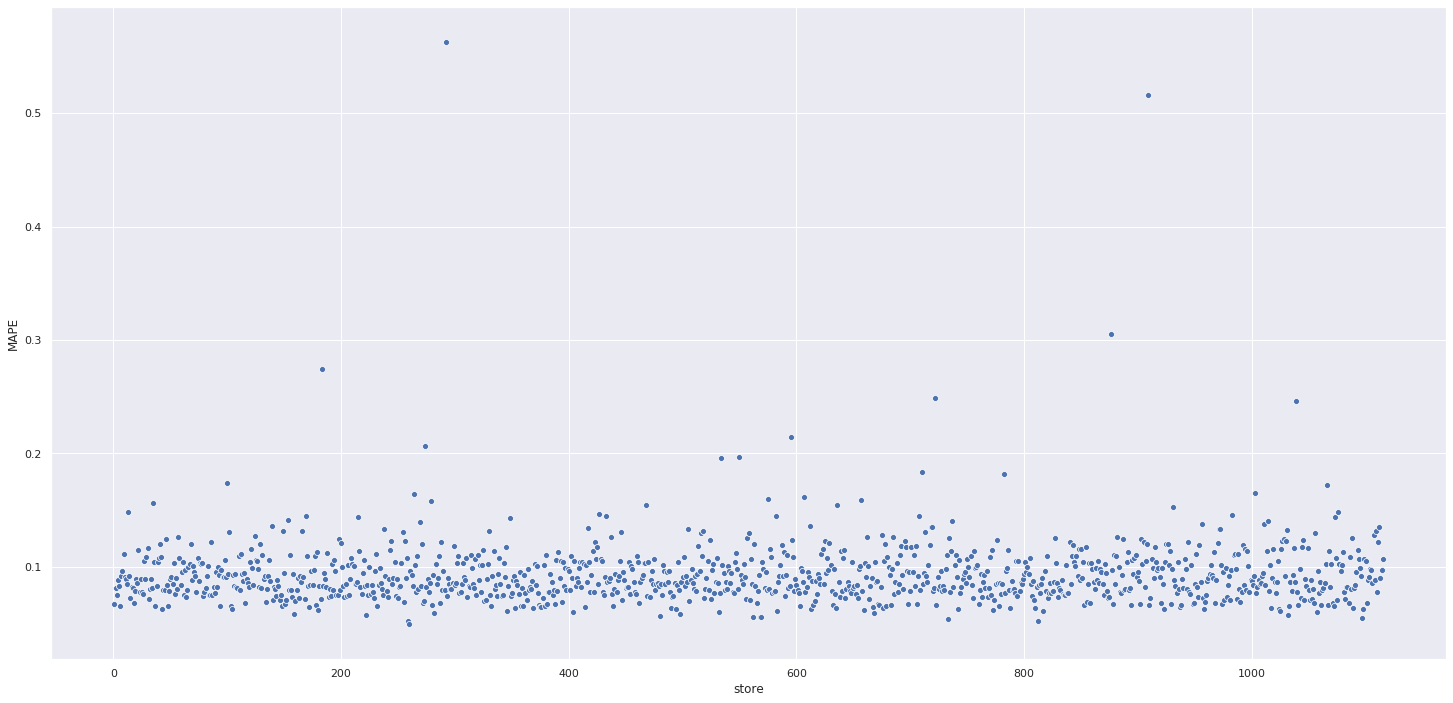

In [98]:
sns.scatterplot('store', 'MAPE', data = df9_2)


## 9.2. Total Performance

In [99]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values'})
df9_3['Values'] = df9_3['Values'].map('${:,.2f}'.format)
df9_3


,Scenario,Values
0,predictions,"$283,727,626.23"
1,worst_scenario,"$257,458,781.08"
2,best_scenario,"$309,996,471.37"


## 9.3. Machine Learning Performance

In [100]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


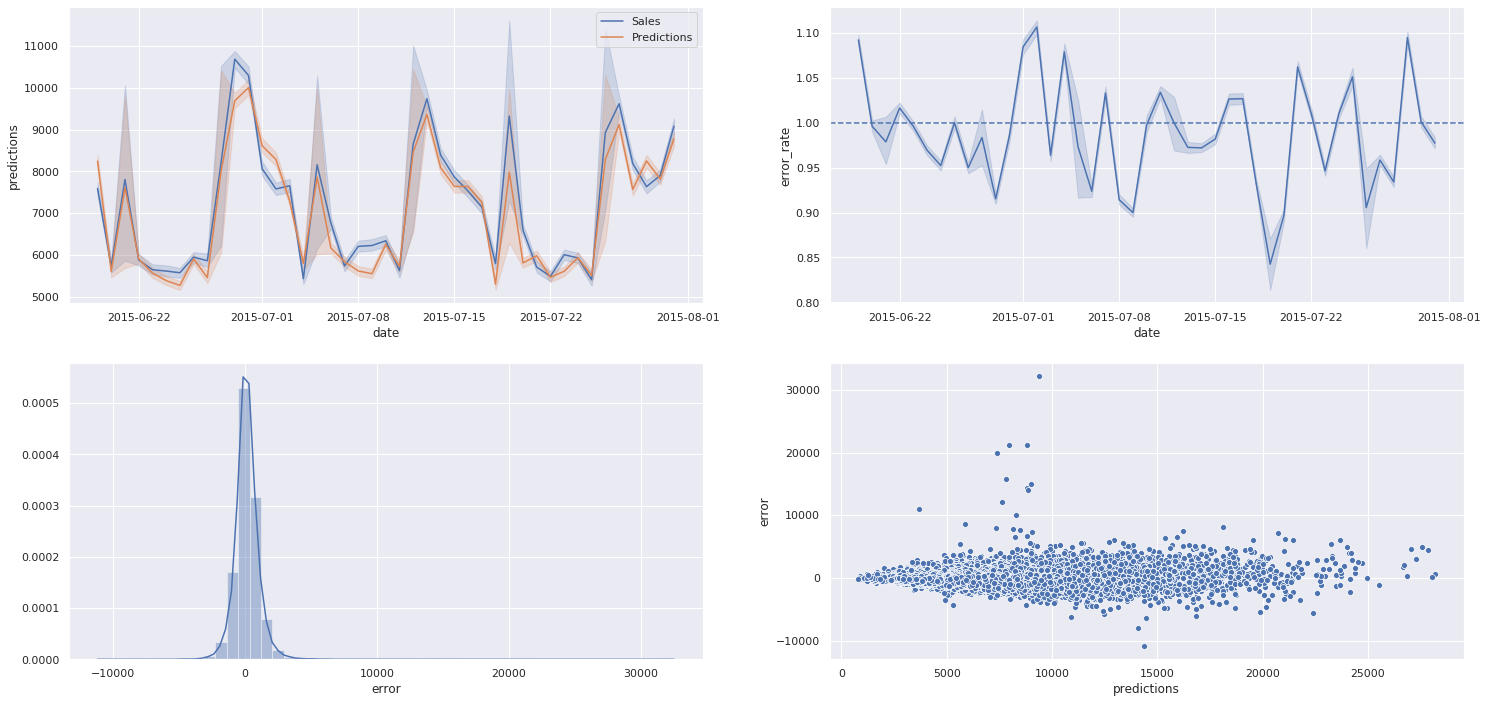

In [101]:
plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label= 'Sales')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label= 'Predictions')

plt.subplot(2, 2, 2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])


# 10.0. Model Deployment

## 10.1. Rossmann Class

In [102]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/dudu/repos/Rossman-Store-Sales/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'Parameters/competition_distance_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'Parameters/year_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'Parameters/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'Parameters/promo_time_week_scaler.pkl', 'rb'))
        self.store_type_encoder            = pickle.load(open(self.home_path + 'Parameters/store_type_encoder.pkl', 'rb'))
    
    def data_cleaning(self, df1):
        
        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # Rename

        df1.columns = cols_new

        ## 1.3. Data Types

        df1['date'] = pd.to_datetime( df1['date'] )


        ## 1.5. Fill NA

        # competition_distance

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        # competition_open_since_month

        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

        # competition_open_since_year 

        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )

        # promo2_since_week           

        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )

        #promo2_since_year           

        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

        # promo_interval

        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace = True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)


        ## 1.6. Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
    
    def feature_engineering(self, df2):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ), axis = 1 )

        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )

        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int 
                                                                                                              )
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' ) 

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 


        # 3.0. Data Filtering
        ## 3.1. Row Filtering

        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Column Selection
        
        cols_drop = ['open', 'promo_interval', 'month_map']

        df2 = df2.drop( cols_drop, axis = 1 )
        
        return df2
    
    
    def data_preparation(self, df5):
        
        ## 5.2. Rescaling

        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        ### 5.3.1. Encoding

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store_type
        df5['store_type'] = self.store_type_encoder.fit_transform(df5['store_type'])
        
        # assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}

        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature Transformation

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 
                                'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 
                                'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        
        # Prediction
        pred = model.predict(test_data)
        
        # Join Prediction into Original Data
        original_data['Prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')


## 10.2. API Handler

## 10.3. APT Tester

In [103]:
import requests

In [104]:
# Loading Test Dataset
df10 = pd.read_csv('/home/dudu/repos/Rossman-Store-Sales/Data/test.csv')


In [105]:
# Merge Test data and Store Data
df_test = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

# Choosing Store for Test Prediction
df_test = df_test[df_test['Store'].isin([22, 35, 47])]

# Cleaning "Closed Days" from data
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)


In [106]:
# Convert DataFrame to json
data = json.dumps(df_test.to_dict(orient = 'records'))


In [107]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict' # Local
url = 'https://rossmann-prediction-model-eff.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

# Request
r = requests.post(url, data = data, headers = header)
print(f'Status Code {r.status_code}')

Status Code 200


In [108]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())


In [109]:
d2 = d1[['store', 'Prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell ${:,.2f} in the next six weeks.'.format(d2.loc[i, 'store'], d2.loc[i,'Prediction']))


Store number 22 will sell $178,256.88 in the next six weeks.
Store number 35 will sell $454,695.59 in the next six weeks.
Store number 47 will sell $312,441.81 in the next six weeks.
